In [4]:
import torch
from stochastic.processes.continuous import FractionalBrownianMotion
import torch.nn as nn
from torch import Tensor
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class fbm_dropout(nn.Module):

    def __init__(self, hurst: float, n_fibers: int, max_epoch: int, input_size: int):
        
        self.fibers_x = []
        self.fibers_y = []
        self.colors = []
        self.n_fibers = n_fibers
        self.input_size = input_size 
        for _ in range(n_fibers):
            fbm_x = FractionalBrownianMotion(hurst, t=1)
            fbm_y = FractionalBrownianMotion(hurst, t=1)

            self.fibers_x.append((fbm_x.sample(100 * max_epoch) + torch.rand((1,)).item()) % 1)
            self.fibers_y.append((fbm_y.sample(100 * max_epoch) + torch.rand((1,)).item()) % 1)
            color = torch.rand((3,))
            color = (color[0].item(), color[1].item(), color[2].item())
            self.colors.append(color)
        
        self.grid = self.get_grid()

    def forward(self, input: Tensor) -> Tensor:
        '''
        given an input, return a dropped out output
        where the dropout probability of each neuron
        is determined by the fbm

        args:
            input: a Tensor with shape (batch_size, self.input_size)

        '''
        mask = self.get_mask(input.shape[1])

        return torch.mul(input, mask)

    def get_mask(self, epoch: int) -> Tensor:

        mask = self.is_touching(epoch)

        return mask

    def get_grid(self):

        n_row = n_col = math.ceil(math.sqrt(self.input_size))

        size_row = 1.0 / n_row
        size_col = 1.0 / n_col

        gap_y = size_row / 4
        gap_x = size_col / 4

        grid = {}
        for i in range(self.input_size):
            y = i // n_row
            x = i % n_col

            x_low = (x * size_col) + gap_x
            y_low = (y * size_row) + gap_y
            x_high = x_low + 2 * gap_x
            y_high = y_low + 2 * gap_y
            grid[i] = ((x_low, x_high), (y_low, y_high))

        return grid

    def is_touching(self, epoch: int):
        
        def is_in(fiber_x, fiber_y, g):
            ((x_low, x_high), (y_low, y_high)) = g
            for x,y  in zip(fiber_x, fiber_y):
                if x_low <= x and x <= x_high and y_low <= y and y <= y_high:
                    return True
            return False

        is_touching = torch.ones((self.input_size,))

        t = epoch*100
        curr_fiber_x = [fiber_x[t:t+100] for fiber_x in self.fibers_x]
        curr_fiber_y = [fiber_y[t:t+100] for fiber_y in self.fibers_y]
        fig, ax = plt.subplots()
        for i in range(self.n_fibers):
            ax.scatter(curr_fiber_x[i], curr_fiber_y[i], s=1.0, color=self.colors[i])
        for i in range(self.input_size):
            ((x_low, x_high), (y_low, y_high)) = self.grid[i]
            ax.add_patch(Rectangle((x_low, y_low), x_high - x_low, y_high - y_low,
                                   facecolor='red', zorder=0))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        plt.show()
        
        for i in range(self.input_size):
            for x, y in zip(curr_fiber_x, curr_fiber_y):
                if is_in(x, y, self.grid[i]):
                    is_touching[i] = 0

        return is_touching

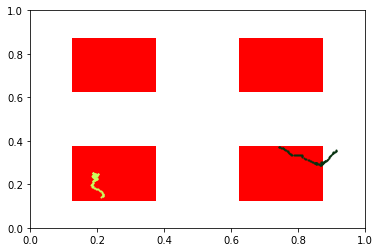

tensor([0., 0., 1., 1.])
tensor(0.5000)


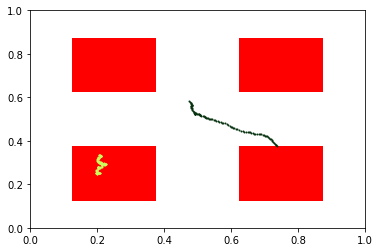

tensor([0., 1., 1., 1.])
tensor(0.2500)


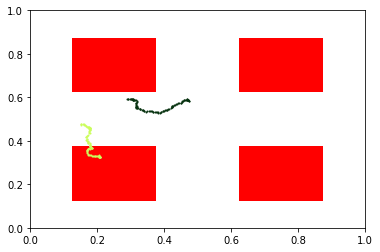

tensor([0., 1., 1., 1.])
tensor(0.2500)


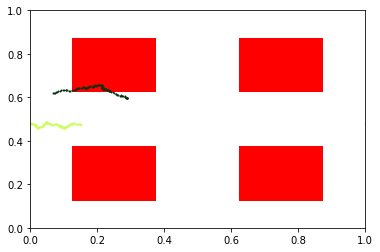

tensor([1., 1., 0., 1.])
tensor(0.2500)


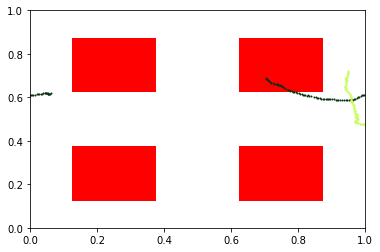

tensor([1., 1., 1., 0.])
tensor(0.2500)


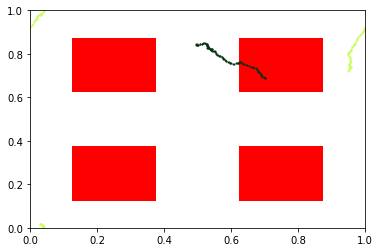

tensor([1., 1., 1., 0.])
tensor(0.2500)


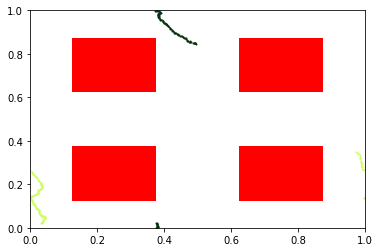

tensor([1., 1., 1., 1.])
tensor(0.)


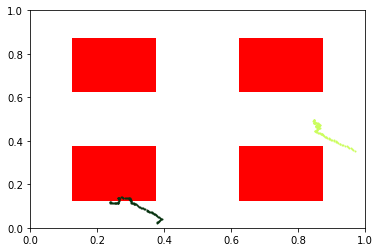

tensor([0., 1., 1., 1.])
tensor(0.2500)


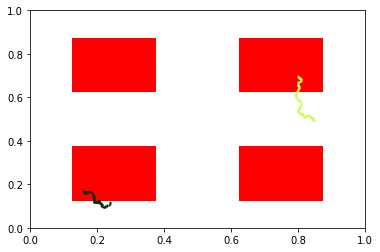

tensor([0., 1., 1., 0.])
tensor(0.5000)


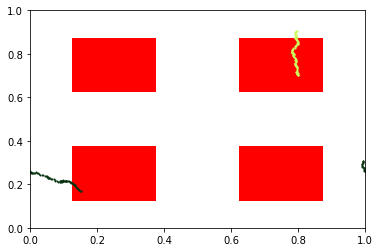

tensor([0., 1., 1., 0.])
tensor(0.5000)


In [9]:
dropout = fbm_dropout(hurst=0.9, n_fibers=2, max_epoch=10, input_size=4)
for epoch in range(10):
    mask = dropout.get_mask(epoch)
    print(mask)
    print((dropout.input_size - torch.sum(mask)) / dropout.input_size)

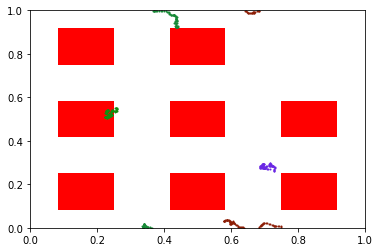

tensor([1., 1., 1., 0., 1., 1., 1., 1.])
tensor(0.1250)


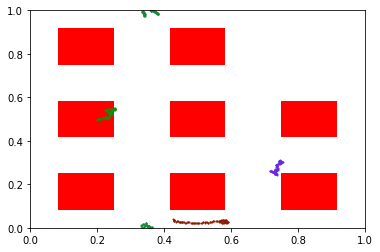

tensor([1., 1., 1., 0., 1., 1., 1., 1.])
tensor(0.1250)


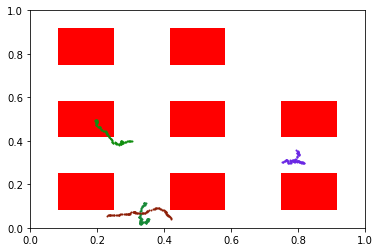

tensor([1., 1., 1., 0., 1., 1., 1., 1.])
tensor(0.1250)


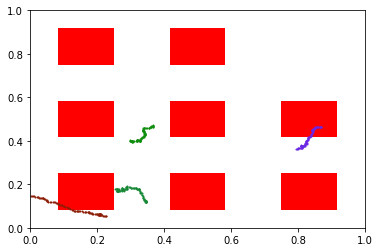

tensor([0., 1., 1., 1., 1., 0., 1., 1.])
tensor(0.2500)


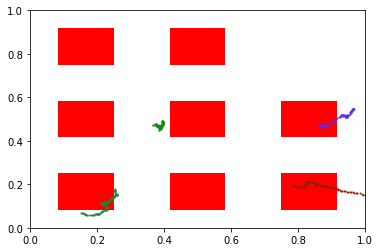

tensor([0., 1., 0., 1., 1., 0., 1., 1.])
tensor(0.3750)


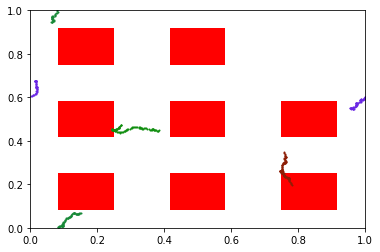

tensor([1., 1., 0., 0., 1., 1., 1., 1.])
tensor(0.2500)


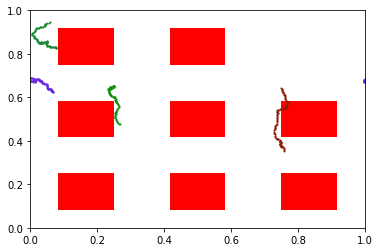

tensor([1., 1., 1., 1., 1., 0., 1., 1.])
tensor(0.1250)


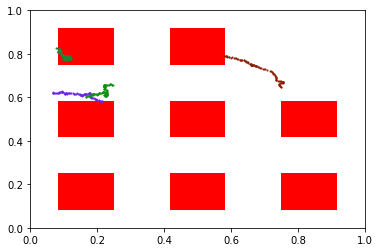

tensor([1., 1., 1., 0., 1., 1., 0., 0.])
tensor(0.3750)


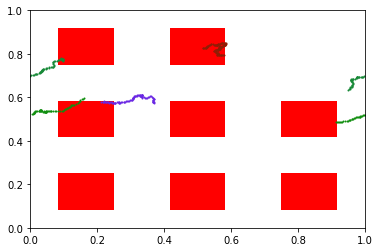

tensor([1., 1., 1., 0., 1., 0., 0., 0.])
tensor(0.5000)


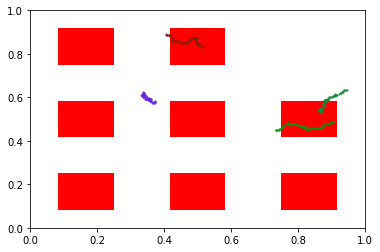

tensor([1., 1., 1., 1., 1., 0., 1., 0.])
tensor(0.2500)


In [13]:
dropout = fbm_dropout(hurst=0.9, n_fibers=4, max_epoch=10, input_size=8)
for epoch in range(10):
    mask = dropout.get_mask(epoch)
    print(mask)
    print((dropout.input_size - torch.sum(mask)) / dropout.input_size)

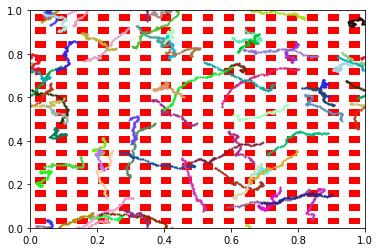

tensor(0.4180)


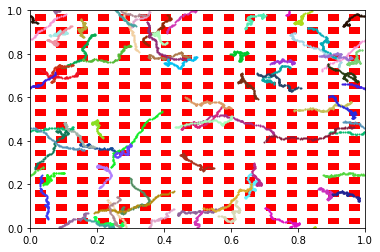

tensor(0.4219)


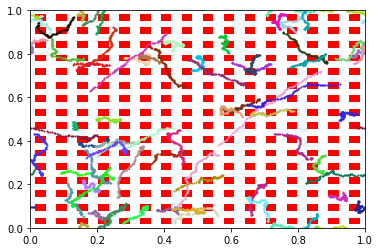

tensor(0.3867)


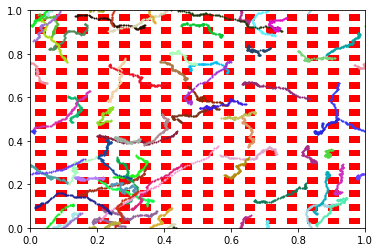

tensor(0.4258)


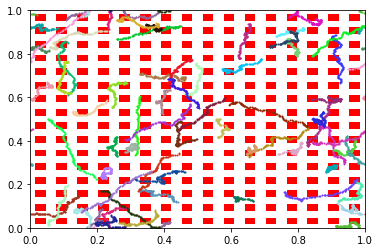

tensor(0.3945)


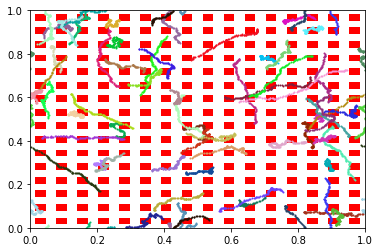

tensor(0.3984)


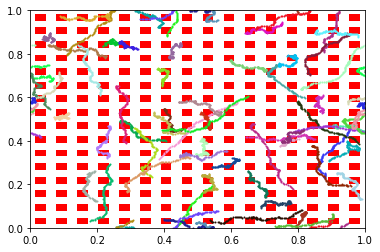

tensor(0.4492)


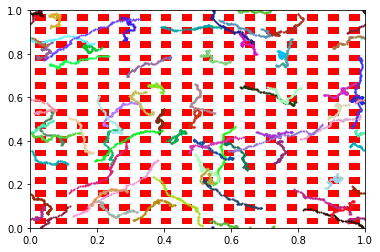

tensor(0.4219)


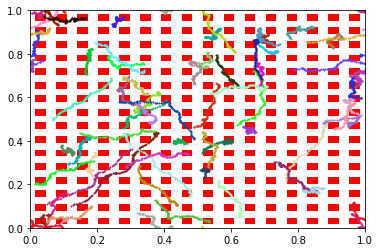

tensor(0.3828)


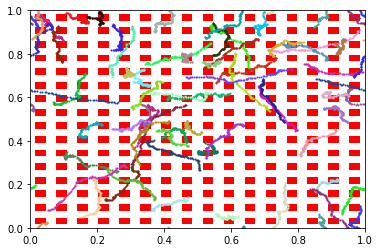

tensor(0.4062)


In [12]:
dropout = fbm_dropout(hurst=0.9, n_fibers=64, max_epoch=10, input_size=256)
for epoch in range(10):
    mask = dropout.get_mask(epoch)
    print((dropout.input_size - torch.sum(mask)) / dropout.input_size)